# Bias Correction for Continuous Y
This notebook attempts to fix the bias for the continuous Y case.

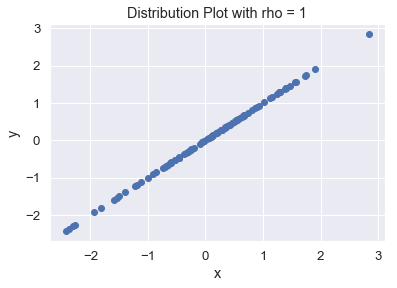

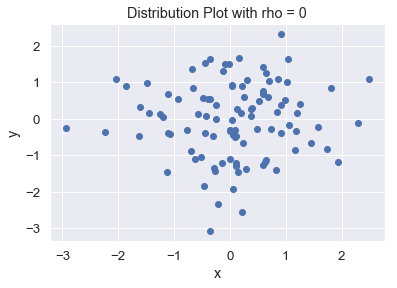

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.2)
%matplotlib inline

def get_cont_sample(n,  rho):
    x_sample = []
    y_sample = []
    means = np.zeros(2)
    cov = np.array(((1, rho), (rho, 1)))
    for i in range(n):
        x = np.random.multivariate_normal(means, cov)
        x_sample.append(x[0])
        y_sample.append(x[1])
    return np.array(x_sample), np.array(y_sample)



X, y = get_cont_sample(100, 1)
plt.scatter(X, y, c = 'b')
plt.title("Distribution Plot with rho = 1")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

X, y = get_cont_sample(100, 0)
plt.scatter(X, y, c = 'b')
plt.title("Distribution Plot with rho = 0")
plt.xlabel("x")
plt.ylabel("y")
plt.show()


In [2]:
from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
import math

np.warnings.filterwarnings('ignore')

def inspect_leaf_elems(leaf_elems):
    count = 0
    for leaf in leaf_elems:
        if len(leaf) > 1:
            print(leaf)
            count += 1
        if count == 5:
            return

def rf_entropy_estimate_bagging(X, y, n_estimators = 500, max_samples = .32, bootstrap = True, depth = 30, min_samples_leaf = 5):
    model = BaggingRegressor(DecisionTreeRegressor(max_depth = depth, min_samples_leaf = min_samples_leaf, max_features = int(math.ceil(X.shape[1]/3))), 
                              n_estimators = n_estimators, 
                              max_samples= max_samples, 
                              bootstrap = bootstrap)
    model.fit(X, y)
    posterior_counts = [[] for _ in range(len(X))]
    for tree_idx in range(n_estimators):
        tree = model[tree_idx]
        unsampled_indices = np.where(model.estimators_samples_[tree_idx] == False)[0]
        total_unsampled = len(unsampled_indices)
        np.random.shuffle(unsampled_indices)
        prob_indices, eval_indices = unsampled_indices[:total_unsampled//2], unsampled_indices[total_unsampled//2:]
        node_counts = tree.tree_.n_node_samples
        leaf_elems = [[] for _ in range(len(node_counts))]
        for prob_index in prob_indices:
            leaf_elems[tree.apply(X[prob_index].reshape(1, -1)).item()].append(y[prob_index])
        for eval_index in eval_indices:
            # for every x, collect all y samples in the leaf nodes x fell into (for entire forest)
            posterior_counts[eval_index].extend(leaf_elems[tree.apply(X[eval_index].reshape(1, -1)).item()])
    # for every x, approximate histogram entropy
    entropy_estimates = []
    for elem in posterior_counts:
        elem.sort()
        entropy = 0.
        hist = np.histogram(elem, bins = "auto")
        pdf = hist[0]/len(elem)
        for i in range(len(pdf)):
            incr = -pdf[i]*np.log(pdf[i]/(hist[1][i + 1] - hist[1][i]))
            if not np.isnan(incr) and incr >= 0:
                entropy += incr
        entropy_estimates.append(entropy)
    return np.mean(entropy_estimates)
np.warnings.filterwarnings('ignore')

X, y = get_cont_sample(500, 1)
rf_entropy_estimate_bagging(np.array(X).reshape(-1, 1), y, 500, .32)



/usr/local/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


0.08738729158795691

## Method 1: Using expected value in each leaf

In [36]:
from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

def inspect_leaf_elems(leaf_elems):
    count = 0
    for leaf in leaf_elems:
        if len(leaf) > 1:
            print(leaf)
            count += 1
        if count == 5:
            return
        
X, y = get_cont_sample(10000, 0)
X = np.array(X).reshape(-1, 1)

n_estimators = 200
max_samples = .32
bootstrap = True
depth = 30
min_samples_leaf = 1

In [37]:
model = BaggingRegressor(DecisionTreeRegressor(max_depth = depth, min_samples_leaf = min_samples_leaf), 
                         n_estimators = n_estimators, 
                         max_samples= max_samples, 
                         bootstrap = bootstrap)
model.fit(X, y)
posterior_counts = [[] for _ in range(len(X))]
for tree_idx in range(n_estimators):
    tree = model[tree_idx]
    unsampled_indices = np.where(model.estimators_samples_[tree_idx] == False)[0]
    total_unsampled = len(unsampled_indices)
    np.random.shuffle(unsampled_indices)
    prob_indices, eval_indices = unsampled_indices[:total_unsampled//2], unsampled_indices[total_unsampled//2:]
    node_counts = tree.tree_.n_node_samples
    leaf_elems = [[] for _ in range(len(node_counts))]
    for prob_index in prob_indices:
        leaf_elems[tree.apply(X[prob_index].item()).item()].append(y[prob_index])
        
    leaf_averages = [[] for _ in range(len(node_counts))]
    for i in range(len(leaf_elems)):
        leaf_averages[i].append(np.mean(leaf_elems[i]).item())
    for eval_index in eval_indices:
        # for every x, collect all y samples in the leaf nodes x fell into (for entire forest)
        posterior_counts[eval_index].extend(leaf_averages[tree.apply(X[eval_index].item()).item()])


np.warnings.filterwarnings('ignore')



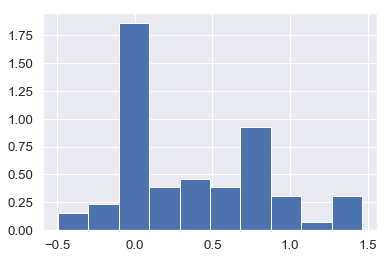

In [38]:
test = np.array(posterior_counts[0])
test = test[~np.isnan(test)]

plt.hist(test, normed=True)
plt.show()

In [39]:
entropy_estimates = []
for elem in posterior_counts:
    elem = np.array(elem)
    elem = elem[~np.isnan(elem)]
    elem.sort()
    entropy = 0.
    hist = np.histogram(elem, bins = "auto")
    pdf = hist[0]/len(elem)
    for i in range(len(pdf)):
        incr = -pdf[i]*np.log(pdf[i]/(hist[1][i + 1] - hist[1][i]))
        if not np.isnan(incr) and incr >= 0:
            entropy += incr
    entropy_estimates.append(entropy)
print(np.mean(entropy_estimates))

0.5861491359458034


## Conclusion: expected value doesn't work

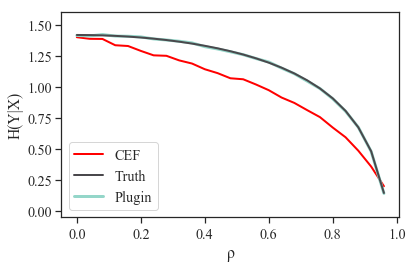

In [46]:
from tqdm import tqdm_notebook

from scipy.stats import multivariate_normal


def estimate_multivariate_entropy(X):
    mean = np.mean(X, axis = 0)
    covar = np.cov(X, rowvar = False)
    return multivariate_normal.entropy(mean, covar)

def plugin_estimate_continuous(X, y):
    joint = np.concatenate((y.reshape(-1, 1), X), axis = 1)
    joint_entropy = estimate_multivariate_entropy(joint)
    h_x = estimate_multivariate_entropy(X)
    cond_entr =  joint_entropy - h_x
    if cond_entr < 0:
        return 0
    return cond_entr

def truth_1d(rho):
    return multivariate_normal.entropy([0, 0], np.array([[1, rho], [rho, 1]])) - multivariate_normal.entropy([0], [1]) 


def get_cond_entropy_vs_mu(n):
    conditional_entropy = []
    plugin_estimate = []
    truth = []
    rho = [i*.04 for i in range(0, 25)]
    for elem in tqdm_notebook(rho):
        X, y = get_cont_sample(n, elem)
        plugin_estimate.append(plugin_estimate_continuous(X.reshape(-1, 1), y))
        conditional_entropy.append(rf_entropy_estimate_bagging(X.reshape(-1, 1), y, 300, .32, depth = 30))
        truth.append(truth_1d(elem))
    return rho, conditional_entropy, plugin_estimate, truth

rhos, cond_entropy, plugin_estimate, truth = get_cond_entropy_vs_mu(20000)

sns.set(font_scale = 1.3)
sns.set_style("ticks")
plt.rcParams["font.family"] = "Times New Roman"
line_est, = plt.plot(rhos, cond_entropy, label = "CEF", linewidth = 2, color = "red")
line_plugin, = plt.plot(rhos, plugin_estimate, label = "Plugin", linewidth = 3, color = "#94D6C9")
line_truth, = plt.plot(rhos, truth, label = "Truth", linewidth = 2, color = "#4a484c")

plt.ylim(ymin = -.05)
plt.ylim(ymax = 1.6)
plt.legend(handles=[line_est, line_truth, line_plugin])
plt.xlabel(u"\u03C1")
plt.ylabel("H(Y|X)")
plt.tight_layout()
plt.savefig("cont_1d_n20000_conv0.png")
plt.show()

# Fix bin width?

In [65]:
from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
import math

np.warnings.filterwarnings('ignore')

def rf_entropy_estimate_bagging(X, y, n_estimators = 500, max_samples = .32, bootstrap = True, depth = 30, min_samples_leaf = 5):
    model = BaggingRegressor(DecisionTreeRegressor(max_depth = depth, min_samples_leaf = min_samples_leaf, max_features = int(math.ceil(X.shape[1]/3))), 
                              n_estimators = n_estimators, 
                              max_samples= max_samples, 
                              bootstrap = bootstrap)
    model.fit(X, y)
    posterior_counts = [[] for _ in range(len(X))]
    for tree_idx in range(n_estimators):
        tree = model[tree_idx]
        unsampled_indices = np.where(model.estimators_samples_[tree_idx] == False)[0]
        total_unsampled = len(unsampled_indices)
        np.random.shuffle(unsampled_indices)
        prob_indices, eval_indices = unsampled_indices[:total_unsampled//2], unsampled_indices[total_unsampled//2:]
        node_counts = tree.tree_.n_node_samples
        leaf_elems = [[] for _ in range(len(node_counts))]
        for prob_index in prob_indices:
            leaf_elems[tree.apply(X[prob_index].reshape(1, -1)).item()].append(y[prob_index])
        for eval_index in eval_indices:
            # for every x, collect all y samples in the leaf nodes x fell into (for entire forest)
            posterior_counts[eval_index].extend(leaf_elems[tree.apply(X[eval_index].reshape(1, -1)).item()])
    # for every x, approximate histogram entropy
    entropy_estimates = []
    for elem in posterior_counts:
        elem.sort()
        entropy = 0.
        hist = np.histogram(elem, bins = "auto")
        pdf = hist[0]/len(elem)
        for i in range(len(pdf)):
            incr = -pdf[i]*np.log(pdf[i])
            if not np.isnan(incr) and incr >= 0 and not np.isinf(incr):
                entropy += incr
        entropy_estimates.append(entropy)
        break
    return np.mean(entropy_estimates)
np.warnings.filterwarnings('ignore')

X, y = get_cont_sample(5000, 0)
rf_entropy_estimate_bagging(np.array(X).reshape(-1, 1), y, 500, .32)



3.061026655743292

## Nonparametric Methods

In [3]:

np.warnings.filterwarnings('ignore')
from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

X, y = get_cont_sample(3000, 0)
X = np.array(X).reshape(-1, 1)

n_estimators = 200
max_samples = .32
bootstrap = True
depth = 30
min_samples_leaf = 1

def inspect_leaf_elems(leaf_elems):
    count = 0
    for leaf in leaf_elems:
        if len(leaf) > 1:
            print(leaf)
            count += 1
        if count == 5:
            return
        
model = BaggingRegressor(DecisionTreeRegressor(max_depth = depth, min_samples_leaf = min_samples_leaf), 
                         n_estimators = n_estimators, 
                         max_samples= max_samples, 
                         bootstrap = bootstrap)
model.fit(X, y)

BaggingRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=30, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=0.32, n_estimators=200, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

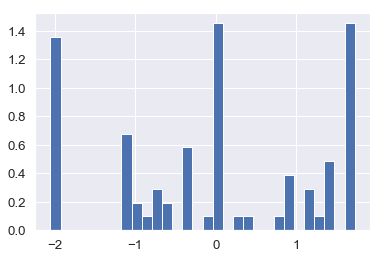

In [4]:
posterior_counts = [[] for _ in range(len(X))]
for tree_idx in range(n_estimators):
    tree = model[tree_idx]
    unsampled_indices = np.where(model.estimators_samples_[tree_idx] == False)[0]
    total_unsampled = len(unsampled_indices)
    np.random.shuffle(unsampled_indices)
    prob_indices, eval_indices = unsampled_indices[:total_unsampled//2], unsampled_indices[total_unsampled//2:]
    node_counts = tree.tree_.n_node_samples
    leaf_elems = [[] for _ in range(len(node_counts))]
    for prob_index in prob_indices:
        leaf_elems[tree.apply(X[prob_index].item()).item()].append(y[prob_index])
    for eval_index in eval_indices:
        # for every x, collect all y samples in the leaf nodes x fell into (for entire forest)
        posterior_counts[eval_index].extend(leaf_elems[tree.apply(X[eval_index].item()).item()])
    
test = posterior_counts[0]
plt.hist(test, normed=True, bins=30)
plt.show()

In [31]:
from sklearn.neighbors import KernelDensity
std = np.std(test)
bandwidth = len(test)**(-1/5)*1.06*std

kde = KernelDensity(bandwidth = bandwidth)
samples = np.array(test).reshape(-1, 1)
kde.fit(samples)

KernelDensity(algorithm='auto', atol=0, bandwidth=0.289031108583934,
       breadth_first=True, kernel='gaussian', leaf_size=40,
       metric='euclidean', metric_params=None, rtol=0)

In [32]:
log_density = kde.score_samples(samples)

In [33]:
density = np.exp(log_density)

In [34]:
entr = 0.
for elem in density:
    entr -= 1/len(samples)*np.log(elem)
print(entr)

1.3983059587199387


### This is good! What about when correlation is 1

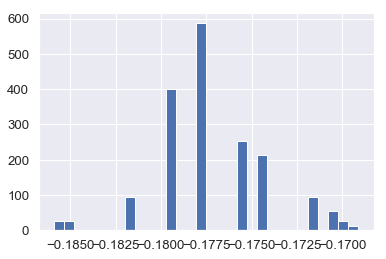

In [35]:

np.warnings.filterwarnings('ignore')
from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

X, y = get_cont_sample(3000, 1)
X = np.array(X).reshape(-1, 1)

n_estimators = 200
max_samples = .32
bootstrap = True
depth = 30
min_samples_leaf = 1

def inspect_leaf_elems(leaf_elems):
    count = 0
    for leaf in leaf_elems:
        if len(leaf) > 1:
            print(leaf)
            count += 1
        if count == 5:
            return
        
model = BaggingRegressor(DecisionTreeRegressor(max_depth = depth, min_samples_leaf = min_samples_leaf), 
                         n_estimators = n_estimators, 
                         max_samples= max_samples, 
                         bootstrap = bootstrap)
model.fit(X, y)
posterior_counts = [[] for _ in range(len(X))]
for tree_idx in range(n_estimators):
    tree = model[tree_idx]
    unsampled_indices = np.where(model.estimators_samples_[tree_idx] == False)[0]
    total_unsampled = len(unsampled_indices)
    np.random.shuffle(unsampled_indices)
    prob_indices, eval_indices = unsampled_indices[:total_unsampled//2], unsampled_indices[total_unsampled//2:]
    node_counts = tree.tree_.n_node_samples
    leaf_elems = [[] for _ in range(len(node_counts))]
    for prob_index in prob_indices:
        leaf_elems[tree.apply(X[prob_index].item()).item()].append(y[prob_index])
    for eval_index in eval_indices:
        # for every x, collect all y samples in the leaf nodes x fell into (for entire forest)
        posterior_counts[eval_index].extend(leaf_elems[tree.apply(X[eval_index].item()).item()])
    
test = posterior_counts[0]
plt.hist(test, normed=True, bins=30)
plt.show()

In [36]:
from sklearn.neighbors import KernelDensity
std = np.std(test)
bandwidth = len(test)**(-1/5)*1.06*std

kde = KernelDensity(bandwidth = bandwidth)
samples = np.array(test).reshape(-1, 1)
kde.fit(samples)
log_density = kde.score_samples(samples)
density = np.exp(log_density)

In [40]:
entr = 0.
for elem in density:
    incr = -1/len(samples)*np.log(elem)
    if np.isnan(incr) or np.isinf(incr) or incr < 0:
        continue
    entr += incr
print(entr)

0.0


### This might be it!!!

In [1]:
from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KernelDensity
import math

X, y = get_cont_sample(3000, 1)
X = np.array(X).reshape(-1, 1)

def rf_entropy_estimate_bagging(X, y, n_estimators = 200, max_samples = .32, bootstrap = True, depth = 30, min_samples_leaf = 5):
    model = BaggingRegressor(DecisionTreeRegressor(max_depth = depth, min_samples_leaf = min_samples_leaf, max_features = int(math.ceil(X.shape[1]/3))), 
                              n_estimators = n_estimators, 
                              max_samples= max_samples, 
                              bootstrap = bootstrap)
    model.fit(X, y)
    posterior_counts = [[] for _ in range(len(X))]
    for tree_idx in range(n_estimators):
        tree = model[tree_idx]
        unsampled_indices = np.where(model.estimators_samples_[tree_idx] == False)[0]
        total_unsampled = len(unsampled_indices)
        np.random.shuffle(unsampled_indices)
        prob_indices, eval_indices = unsampled_indices[:total_unsampled//2], unsampled_indices[total_unsampled//2:]
        node_counts = tree.tree_.n_node_samples
        leaf_elems = [[] for _ in range(len(node_counts))]
        for prob_index in prob_indices:
            leaf_elems[tree.apply(X[prob_index].reshape(1, -1)).item()].append(y[prob_index])
        for eval_index in eval_indices:
            # for every x, collect all y samples in the leaf nodes x fell into (for entire forest)
            posterior_counts[eval_index].extend(leaf_elems[tree.apply(X[eval_index].reshape(1, -1)).item()])
    # for every x, approximate histogram entropy
    entropy_estimates = []
    for sample in posterior_counts:
        sample = np.array(sample).reshape(-1, 1)
        std = np.std(sample)
        bandwidth = len(sample)**(-1/5)*1.06*std
        kde = KernelDensity(bandwidth = bandwidth)
        kde.fit(sample)
        density = np.exp(kde.score_samples(sample))
        entr = 0.
        # this can be sped up
        for elem in density:
            incr = -1/len(sample)*np.log(elem)
            if np.isnan(incr) or np.isinf(incr) or incr < 0:
                continue
            entr += incr
        entropy_estimates.append(entr)
    return np.mean(entropy_estimates)

np.warnings.filterwarnings('ignore')

X, y = get_cont_sample(1000, 1)
rf_entropy_estimate_bagging(np.array(X).reshape(-1, 1), y, 200, .32)



/usr/local/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


NameError: name 'get_cont_sample' is not defined

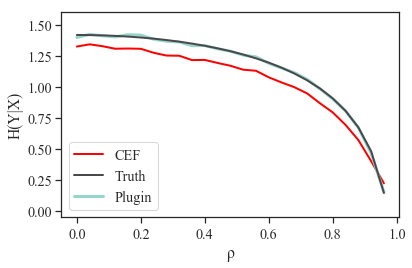

In [6]:
from tqdm import tqdm_notebook

from scipy.stats import multivariate_normal


def estimate_multivariate_entropy(X):
    mean = np.mean(X, axis = 0)
    covar = np.cov(X, rowvar = False)
    return multivariate_normal.entropy(mean, covar)

def plugin_estimate_continuous(X, y):
    joint = np.concatenate((y.reshape(-1, 1), X), axis = 1)
    joint_entropy = estimate_multivariate_entropy(joint)
    h_x = estimate_multivariate_entropy(X)
    cond_entr =  joint_entropy - h_x
    if cond_entr < 0:
        return 0
    return cond_entr

def truth_1d(rho):
    return multivariate_normal.entropy([0, 0], np.array([[1, rho], [rho, 1]])) - multivariate_normal.entropy([0], [1]) 


def get_cond_entropy_vs_mu(n):
    conditional_entropy = []
    plugin_estimate = []
    truth = []
    rho = [i*.04 for i in range(0, 25)]
    for elem in tqdm_notebook(rho):
        X, y = get_cont_sample(n, elem)
        plugin_estimate.append(plugin_estimate_continuous(X.reshape(-1, 1), y))
        conditional_entropy.append(rf_entropy_estimate_bagging(X.reshape(-1, 1), y, 300, .32, depth = 30))
        truth.append(truth_1d(elem))
    return rho, conditional_entropy, plugin_estimate, truth

rhos, cond_entropy, plugin_estimate, truth = get_cond_entropy_vs_mu(5000)

sns.set(font_scale = 1.3)
sns.set_style("ticks")
plt.rcParams["font.family"] = "Times New Roman"
line_est, = plt.plot(rhos, cond_entropy, label = "CEF", linewidth = 2, color = "red")
line_plugin, = plt.plot(rhos, plugin_estimate, label = "Plugin", linewidth = 3, color = "#94D6C9")
line_truth, = plt.plot(rhos, truth, label = "Truth", linewidth = 2, color = "#4a484c")

plt.ylim(ymin = -.05)
plt.ylim(ymax = 1.6)
plt.legend(handles=[line_est, line_truth, line_plugin])
plt.xlabel(u"\u03C1")
plt.ylabel("H(Y|X)")
plt.tight_layout()
plt.savefig("cont_1d_n5000_conv0.png")
plt.show()

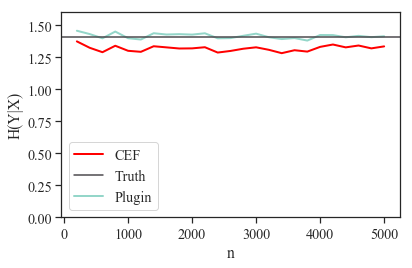

In [7]:
from tqdm import tqdm_notebook

def get_cond_entropy_vs_n(rho):
    conditional_entropy = []
    plugin_estimate = []
    sample_sizes = [i*200 for i in range(1, 26)]
    for elem in tqdm_notebook(sample_sizes):
        X, y = get_cont_sample(elem, rho)
        plugin_estimate.append(plugin_estimate_continuous(X.reshape(-1, 1), y))
        conditional_entropy.append(rf_entropy_estimate_bagging(X.reshape(-1, 1), y, 200, .32, depth = 30))
    return sample_sizes, conditional_entropy, plugin_estimate

sample_sizes, cond_entropy, plugin_estimate = get_cond_entropy_vs_n(0)
sns.set(font_scale = 1.3)
sns.set_style("ticks")
plt.rcParams["font.family"] = "Times New Roman"
line_plugin, = plt.plot(sample_sizes, plugin_estimate, label = "Plugin", linewidth = 2, color = "#94D6C9")
line_est, = plt.plot(sample_sizes, cond_entropy, label = "CEF", linewidth = 2, color = "red")
line_true = plt.axhline(y=1.41, color='#4a484c', linestyle='-', label = "Truth")
plt.xlabel("n")
plt.ylabel("H(Y|X)")
plt.legend(handles=[line_est, line_true, line_plugin])
plt.ylim(ymax = 1.6)
plt.ylim(ymin = 0)
plt.tight_layout()
plt.savefig("cont_1d_rho0_kde.png")
plt.show()

In [6]:
from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KernelDensity
import math

X, y = get_cont_sample(3000, 1)
X = np.array(X).reshape(-1, 1)

def rf_entropy_estimate_bagging(X, y, n_estimators = 200, max_samples = .32, bootstrap = True, depth = 30, min_samples_leaf = 5):
    model = BaggingRegressor(DecisionTreeRegressor(max_depth = depth, min_samples_leaf = min_samples_leaf, max_features = int(math.ceil(X.shape[1]/3))), 
                              n_estimators = n_estimators, 
                              max_samples= max_samples, 
                              bootstrap = bootstrap)
    model.fit(X, y)
    posterior_counts = [[] for _ in range(len(X))]
    for tree_idx in range(n_estimators):
        tree = model[tree_idx]
        unsampled_indices = np.where(model.estimators_samples_[tree_idx] == False)[0]
        total_unsampled = len(unsampled_indices)
        np.random.shuffle(unsampled_indices)
        prob_indices, eval_indices = unsampled_indices[:total_unsampled//2], unsampled_indices[total_unsampled//2:]
        node_counts = tree.tree_.n_node_samples
        leaf_elems = [[] for _ in range(len(node_counts))]
        for prob_index in prob_indices:
            leaf_elems[tree.apply(X[prob_index].reshape(1, -1)).item()].append(y[prob_index])
        for eval_index in eval_indices:
            # for every x, collect all y samples in the leaf nodes x fell into (for entire forest)
            posterior_counts[eval_index].extend(leaf_elems[tree.apply(X[eval_index].reshape(1, -1)).item()])
    # for every x, approximate histogram entropy
    entropy_estimates = []
    for sample in posterior_counts:
        sample = np.array(sample).reshape(-1, 1)
        std = np.std(sample)
        bandwidth = len(sample)**(-1/3)*3.49*std
        kde = KernelDensity(bandwidth = bandwidth)
        kde.fit(sample)
        density = np.exp(kde.score_samples(sample))
        entr = 0.
        # this can be sped up
        for elem in density:
            incr = -1/len(sample)*np.log(elem)
            if np.isnan(incr) or np.isinf(incr) or incr < 0:
                continue
            entr += incr
        entropy_estimates.append(entr)
    return np.mean(entropy_estimates)

np.warnings.filterwarnings('ignore')

X, y = get_cont_sample(3000, 1)
rf_entropy_estimate_bagging(np.array(X).reshape(-1, 1), y, 200, .32)



0.012873613538383618

In [8]:
from tqdm import tqdm_notebook

from scipy.stats import multivariate_normal


def estimate_multivariate_entropy(X):
    mean = np.mean(X, axis = 0)
    covar = np.cov(X, rowvar = False)
    return multivariate_normal.entropy(mean, covar)

def plugin_estimate_continuous(X, y):
    joint = np.concatenate((y.reshape(-1, 1), X), axis = 1)
    joint_entropy = estimate_multivariate_entropy(joint)
    h_x = estimate_multivariate_entropy(X)
    cond_entr =  joint_entropy - h_x
    if cond_entr < 0:
        return 0
    return cond_entr

def truth_1d(rho):
    return multivariate_normal.entropy([0, 0], np.array([[1, rho], [rho, 1]])) - multivariate_normal.entropy([0], [1]) 


def get_cond_entropy_vs_mu(n):
    conditional_entropy = []
    plugin_estimate = []
    truth = []
    rho = [i*.04 for i in range(0, 25)]
    for elem in tqdm_notebook(rho):
        X, y = get_cont_sample(n, elem)
        plugin_estimate.append(plugin_estimate_continuous(X.reshape(-1, 1), y))
        conditional_entropy.append(rf_entropy_estimate_bagging(X.reshape(-1, 1), y, 300, .32, depth = 30))
        truth.append(truth_1d(elem))
    return rho, conditional_entropy, plugin_estimate, truth

rhos, cond_entropy, plugin_estimate, truth = get_cond_entropy_vs_mu(3000)

sns.set(font_scale = 1.3)
sns.set_style("ticks")
plt.rcParams["font.family"] = "Times New Roman"
line_est, = plt.plot(rhos, cond_entropy, label = "CEF", linewidth = 2, color = "red")
line_plugin, = plt.plot(rhos, plugin_estimate, label = "Plugin", linewidth = 3, color = "#94D6C9")
line_truth, = plt.plot(rhos, truth, label = "Truth", linewidth = 2, color = "#4a484c")

plt.ylim(ymin = -.05)
plt.ylim(ymax = 1.6)
plt.legend(handles=[line_est, line_truth, line_plugin])
plt.xlabel(u"\u03C1")
plt.ylabel("H(Y|X)")
plt.tight_layout()
plt.savefig("cont_1d_n3000_conv0_scott.png")
plt.show()

KeyboardInterrupt: 